In [1]:
import os
import operator
import numpy as np
import pandas as pd
import sys
import colorcet as cc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from matplotlib import cm
from matplotlib.colors import ListedColormap

## __SI:__ Antimicrobial resistance level and conjugation permissiveness shape plasmid distribution in clinical enterobacteria

### 5. Computer experiments: multistrain dose-response assays

In this notebook, we implement dose-response experiments designed to assess the impact of various antibiotic concentrations on mixed bacterial populations, specifically _Klebsiella spp._ and _E. coli._ These dose-response experiments comprise computational simulations initialized with a multi-strain bacterial community composed of 20 strains. Specifically, one member of the community carries the pOXA-48 plasmid, starting at a frequency of $0.01\%$ of the total density, a scenario we refer to as a _'plasmid invasion experiment'_.

Throughout the simulations, we monitor the density of each strain and the fraction of each strain carrying the resistance plasmid under different antibiotic concentrations. Our intention is to generate a comprehensive antibiotic resistance fitness landscape for mixed bacterial populations and to observe the plasmid dynamics within this context.
By calculating the competitive fitness of each bacterial strain under varying levels of antibiotic pressure, we aim to quantify the plasmid-host associations. The dose-response experiments thus serve as a method to examine the survival and growth strategies employed by different bacterial strains under varied antibiotic conditions.

### Experimental parameters

In [3]:
sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *
from pOXA48_S3 import *

%run src/pOXA48_parameters
print_expe_params(expe_params)


Experimental Parameters:
------------------------------------------------
	Initial bacterial density (B0): 1000000.0
	Maximum drug concentration (A_max): 131072
	Antibiotic degradation rates (alphas): [1.e-10 1.e-12]
	Length of experiment (T): 24
	Initial resource concentration (S0): 1.0
	Resource decay rate (d): 0.1
	Extinction threshold: 1.0
------------------------------------------------


### Model parameters

In [4]:
num_days=10

istrains=strains_subset

powers = np.arange(-4.0, 20.0, 0.2)  # array of powers of two exponents
Amax_values=np.power(2.0, powers)  # calculate 2 raised to each exponent

type_experiment='invasion'

blue = '#129FE4'
red = '#E9666F'

figPathN="%sN%s/"%(figPath, num_days)
if not os.path.exists(figPathN):
  os.makedirs(figPathN)

In [5]:
model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)

display_model_params(model_params, strains_subset)

╒════╤══════════╤══════════╤══════════╤════════╤══════════╤═══════╤═════════════╤══════════╤═════════════╤════════════╤═════════════╕
│    │ name     │ strain   │ specie   │ type   │      PCN │   MIC │   conj_rate │      VKm │         rho │   seg_rate │       kappa │
╞════╪══════════╪══════════╪══════════╪════════╪══════════╪═══════╪═════════════╪══════════╪═════════════╪════════════╪═════════════╡
│  2 │ PF_EC02  │ C002     │ E        │ TC     │   1.3351 │  8192 │    nan      │ 7.6e-10  │ 5.50386e+08 │      0.002 │ 0.0625      │
├────┼──────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│  3 │ PF_EC03  │ C006     │ E        │ TC     │   2.2371 │  6144 │    nan      │ 7.6e-10  │ 8.90018e+08 │      0.002 │ 0.0625      │
├────┼──────────┼──────────┼──────────┼────────┼──────────┼───────┼─────────────┼──────────┼─────────────┼────────────┼─────────────┤
│  7 │ PF_EC07  │ C022     │ E        │ TC     │   1.0054 │  6

In [6]:

istrains=strains_subset




def simulate_doseResponse_multistrain(model_params, istrains, Amax_values, type_experiment='invasion', iexpe=0):

    densityT = []
    for this_Amax in Amax_values:
      Es_norm=[np.ones(num_days)]
      E = [this_Amax * e for e in Es_norm[iexpe]]
      Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, ts, ys, params_list = simulate_environment_multistrain(model_params, istrains, E, type_experiment)

        # Get final points
      final_times, final_ys = get_final_points(ts, ys)

      # Analyze simulation results
      Btot, BpE, BpK, BfE, BfK, freqpE, freqpK  = analyze_simulation(model_params, istrains, final_ys)

      densities = final_ys[-1][2:]

      densityT.append(densities)

    return np.array(densityT)


densityT=simulate_doseResponse_multistrain(model_params, istrains, Amax_values, type_experiment)

........................................................................................................................

In [7]:


def plot_doseResponseSpecies_multistrain(model_params, istrains, A_values, densityT, ax):
    """
    Plot dose-response curves for multiple strains of plasmid-free and plasmid-bearing cells.

    This function generates dose-response curves for each strain. Different species are plotted with
    different colors, and within each species, different strains are differentiated by line style.
    The total bacterial density is plotted as a solid black line.

    Parameters:
    model_params: pandas DataFrame
        DataFrame that contains the parameters for each strain.
    istrains: list
        List of strain indices. These indices correspond to rows in the model parameters DataFrame.
    A_values: numpy array
        Array of drug concentration values.
    densityT: numpy array
        Array of total bacterial densities. The first dimension corresponds to drug concentration,
        and the second dimension corresponds to strain.
    ax: matplotlib Axes
        The Axes object to draw the plot onto.
    """

    num_strains = int(np.round(len(istrains)))
    species_list = model_params['specie'].unique()
    color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}

    # Plot TC strains with dotted lines
    va=np.zeros(len(A_values))
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, densityT[:, i], '-', color=color)
        #ax.fill_between(A_values, va, va+densityT[:, i], color=color, alpha=0.9)

        va+=densityT[:, i]

    # Plot WT strains with solid lines
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, densityT[:, i+num_strains], ':', color=color)
        #ax.fill_between(A_values, va, va+densityT[:, i+num_strains], color=color, alpha=0.5)

        va+=densityT[:, i+num_strains]


    # Plot total bacterial density as a solid line
    ax.plot(A_values, va, color='black', linewidth=2)

    ax.set_xlabel('Drug concentration (mg/L)', fontsize=16)
    ax.set_ylabel('Strain density (log)', fontsize=16)
    ax.set_xscale('log', base=2)
    ax.set_ylim([1e-2, 1.1*np.max(va)])
    ax.set_xlim([A_values[0], A_values[-1]])


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    #ax.legend()

def plot_doseResponseAreaSpecies_multistrain(model_params, istrains, A_values, densityT, ax):
    """
    Plot cumulative dose-response area curves for multiple strains of plasmid-free and plasmid-bearing cells.

    This function generates cumulative dose-response curves for each strain where the area under each
    curve corresponds to the total bacterial density. Different species are plotted with different
    colors, and within each species, different strains are differentiated by line style. The total
    bacterial density is plotted as a solid black line.

    Parameters:
    model_params: pandas DataFrame
        DataFrame that contains the parameters for each strain.
    istrains: list
        List of strain indices. These indices correspond to rows in the model parameters DataFrame.
    A_values: numpy array
        Array of drug concentration values.
    densityT: numpy array
        Array of total bacterial densities. The first dimension corresponds to drug concentration,
        and the second dimension corresponds to strain.
    ax: matplotlib Axes
        The Axes object to draw the plot onto.
    """
    # Create color mapping
    num_strains = int(np.round(len(istrains)))
    species_list = model_params['specie'].unique()
    #color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}

    # Custom colormaps
    colors_blue = ['#D3E4FA', '#129FE4']
    cmap_custom_blue = mcolors.LinearSegmentedColormap.from_list("", colors_blue)

    colors_red = ['#FFC0CB', '#E9666F']
    cmap_custom_red = mcolors.LinearSegmentedColormap.from_list("", colors_red)

    # Then use these custom colormaps in your color_mapping
    color_mapping = {species: cm.get_cmap(color, num_strains)
                    for species, color in zip(species_list, [cmap_custom_red, cmap_custom_blue])}


    # Plot TC strains with dotted lines
    va=np.zeros(len(A_values))
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, va+densityT[:, i], ':', color=color)
        ax.fill_between(A_values, va, va+densityT[:, i], color=color, alpha=0.65)

        va+=densityT[:, i]

    # Plot WT strains with solid lines
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, va+densityT[:, i+num_strains], '-', color=color)
        ax.fill_between(A_values, va, va+densityT[:, i+num_strains], color=color, alpha=0.25, hatch='//')

        va+=densityT[:, i+num_strains]


    # Plot total bacterial density as a solid line
    ax.plot(A_values, va, color='black', linewidth=2)

    #ax.set_xlabel('Drug concentration', fontsize=16)
    ax.set_ylabel('Cumulative density', fontsize=16)
    ax.set_xscale('log', base=2)
    ax.set_ylim([1e-2, 1.2*np.max(va)])
    ax.set_xlim([A_values[0], A_values[-1]])

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    #ax.legend()


<ipython-input-7-d31354b5a37c>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}
<ipython-input-7-d31354b5a37c>:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = {species: cm.get_cmap(color, num_strains)


Exporting ./figures/N10/sim_doseResponse_N10.pdf


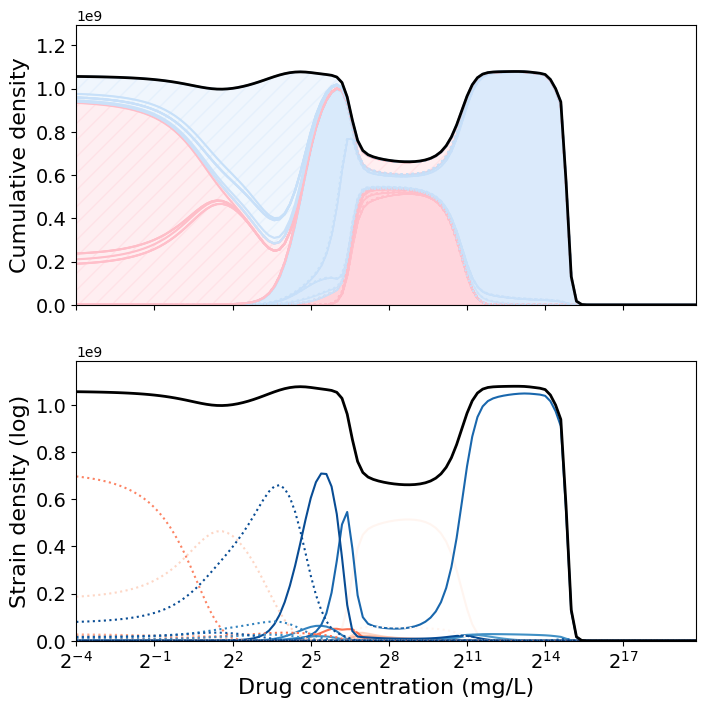

In [8]:

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

plot_doseResponseSpecies_multistrain(model_params, istrains, Amax_values, densityT, axs[1])

plot_doseResponseAreaSpecies_multistrain(model_params, istrains, Amax_values, densityT, axs[0])


plot_path="%ssim_doseResponse_N%s.pdf"%(figPathN, num_days)
print("Exporting %s"%plot_path)
plt.savefig(plot_path)

#plt.tight_layout()
plt.show()



In [9]:



def plot_doseResponse_multistrain(model_params, istrains, A_values, densityT, ax):
    """
    Plot dose-response curves for multiple strains of plasmid-bearing and plasmid-free cells.

    This function generates dose-response curves for each strain, differentiating plasmid-bearing and
    plasmid-free strains with different line styles. The strains are color-coded.

    Parameters:
    model_params: pandas DataFrame
        DataFrame that contains the parameters for each strain.
    istrains: list
        List of strain indices. These indices correspond to rows in the model parameters DataFrame.
    A_values: numpy array
        Array of drug concentration values.
    densityT: numpy array
        Array of total bacterial densities. The first dimension corresponds to drug concentration,
        and the second dimension corresponds to strain.
    ax: matplotlib Axes
        The Axes object to draw the plot onto.
    """
    num_strains = int(len(istrains))
    cmap_strains = cc.glasbey_dark[:tot_strains]

    # Plot TC strains with dotted lines
    for i in range(num_strains):
        if np.max(densityT[:, i]) > 1e7 or np.max(densityT[:, i+num_strains])>1e7: # Only add a legend entry if the maximum density is >1e6
          ax.plot(A_values, densityT[:, i], '-', color=cmap_strains[istrains[i]], label=f'{strain_names[istrains[i]]}')
        else:
          ax.plot(A_values, densityT[:, i], '-', color=cmap_strains[istrains[i]])

    # Plot WT strains with solid lines
    for i in range(num_strains):
        ax.plot(A_values, densityT[:, i+num_strains], ':', color=cmap_strains[istrains[i]])

    #ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Strain density (log)', fontsize=16)
    ax.set_xscale('log', base=2)
    #ax.set_yscale('log', base=10)
    ax.set_ylim([1e-2, 1.2e9])
    ax.set_xlim([A_values[0], A_values[-1]])


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    ax.set_xlabel('Drug concentration (mg/L)', fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)



def plot_doseResponseAreas_multistrain(model_params, istrains, A_values, densityT, ax):
    """
    Plot cumulative dose-response areas for multiple strains of plasmid-bearing and plasmid-free cells.

    This function generates cumulative dose-response areas for each strain, differentiating plasmid-bearing and
    plasmid-free strains with different fill styles. The strains are color-coded.

    Parameters:
    model_params: pandas DataFrame
        DataFrame that contains the parameters for each strain.
    istrains: list
        List of strain indices. These indices correspond to rows in the model parameters DataFrame.
    A_values: numpy array
        Array of drug concentration values.
    densityT: numpy array
        Array of total bacterial densities. The first dimension corresponds to drug concentration,
        and the second dimension corresponds to strain.
    ax: matplotlib Axes
        The Axes object to draw the plot onto.
    """
    num_strains = int(len(istrains))
    cmap_strains = cc.glasbey_dark[:tot_strains]

    # Plot TC strains with dotted lines
    va=np.zeros(len(A_values))
    for i in range(num_strains):
        #ax.plot(A_values, va+densityT[:, i], '-', color=cmap_strains[i])
        ax.fill_between(A_values, va, va+densityT[:, i], color=cmap_strains[istrains[i]], alpha=0.9)

        va+=densityT[:, i]

    # Plot WT strains with solid lines
    for i in range(num_strains):
        #ax.plot(A_values, va+densityT[:, i+num_strains], ':', color=cmap_strains[i])
        ax.fill_between(A_values, va, va+densityT[:, i+num_strains], color=cmap_strains[istrains[i]], alpha=0.5, hatch='//')

        va+=densityT[:, i+num_strains]

    ax.set_ylabel('Cumulative density', fontsize=16)
    ax.set_xscale('log', base=2)
    ax.set_ylim([1e-2, 1.2e9]) #1.1*np.max(densityT)
    ax.set_xlim([A_values[0], A_values[-1]])


    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)


    handles, labels = ax.get_legend_handles_labels()
    if labels:
        ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)



Exporting ./figures/N10/sim_doseResponse_N10.pdf


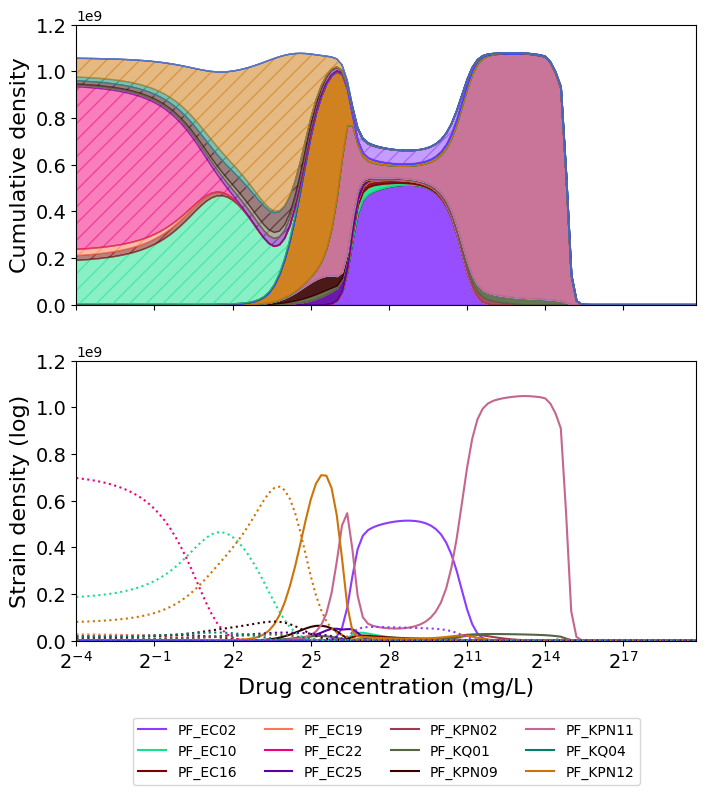

In [10]:

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Plot dose-response frequencies
plot_doseResponseAreas_multistrain(model_params, istrains, Amax_values, densityT, axs[0])

# Plot dose-response area
plot_doseResponse_multistrain(model_params, istrains, Amax_values, densityT, axs[1])

plot_path="%ssim_doseResponse_N%s.pdf"%(figPathN, num_days)
print("Exporting %s"%plot_path)
plt.savefig(plot_path)
plt.show()


In [11]:
def plot_fractionPlasmidBearing_multistrain(model_params, istrains, A_values, densities, ax):
    """
    Plot the fraction of plasmid-bearing cells of each species in response to different drug concentrations.

    This function calculates the relative abundance of each strain at each drug concentration and then calculates the
    fraction of plasmid-bearing cells of each species at each drug concentration. The results are plotted as an area
    chart, with different colors representing different species, and different fill styles representing plasmid-bearing
    and plasmid-free cells.

    Parameters:
    model_params: pandas DataFrame
        DataFrame that contains the parameters for each strain.
    istrains: list
        List of strain indices. These indices correspond to rows in the model parameters DataFrame.
    A_values: numpy array
        Array of drug concentration values.
    densities: list of numpy arrays
        List of arrays of bacterial densities. The first dimension of each array corresponds to drug concentration,
        and the second dimension corresponds to strain.
    ax: matplotlib Axes
        The Axes object to draw the plot onto.
    """

    species_list = list(model_params['specie'].unique())
    color_mapping = {species: color for species, color in zip(species_list, [red, blue])}
    densities = np.array(densities)

    # Calculate total density at each point
    total_density = np.sum(densities, axis=1)

    # Calculate relative abundance at each point
    relative_abundances = densities / total_density[:, np.newaxis]

    fractions_species = np.zeros((len(A_values), len(species_list), 2))

    # Calculate the fraction of plasmid-bearing cells of each species
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        fractions_species[:, species_list.index(species), 0] += relative_abundances[:, i]  # WT
        fractions_species[:, species_list.index(species), 1] += relative_abundances[:, len(istrains) + i]  # TC

    # Plot fraction of plasmid-bearing cells with area chart
    cumulative_fraction = np.zeros(len(A_values))

    for i, species in enumerate(species_list):
        for j in range(2):  # Loop over WT and TC
            ax.fill_between(A_values, cumulative_fraction, cumulative_fraction + fractions_species[:, i, j],
                            color=color_mapping[species], alpha=0.8 if j == 0 else 0.2,
                            hatch='//' if j == 1 else None)
            cumulative_fraction += fractions_species[:, i, j]

    ax.set_xlabel('Drug concentration (mg/L)')
    ax.set_ylabel('Fraction of plasmid-bearing cells')
    ax.set_xscale('log', base=2)
    ax.set_ylim([0, 1])
    ax.set_xlim([A_values[0], A_values[-1]])

    #ax.legend()


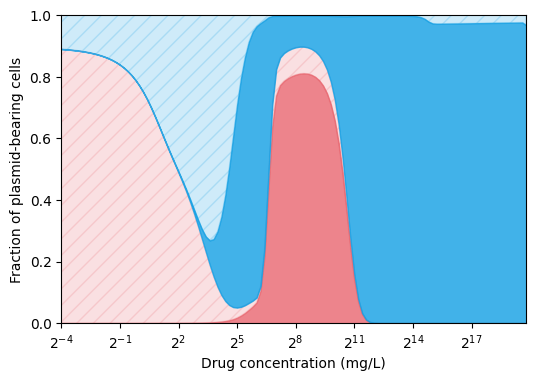

<Figure size 640x480 with 0 Axes>

In [12]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_fractionPlasmidBearing_multistrain(model_params, istrains, Amax_values, densityT, ax)
plt.show()

plot_path="%ssim_doseResponseFreqs_N%s.pdf"%(figPathN, num_days)
plt.savefig(plot_path)